In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle

In [2]:
combined_data = pd.read_csv('/home/thu/INT3041E_AI_PM2.5-Concentration-Estimation/model/cleandata.csv')
combined_data.head()

,Unnamed: 0,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,...,RH,PRES2M,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI
0,0,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,18.939997,...,74.750000,102197.203125,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203
1,1,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,18.939997,...,74.750000,102197.203125,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537
2,2,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,18.879999,...,73.687500,102228.796875,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304
3,3,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,18.939997,...,74.750000,102197.203125,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613
4,4,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,20.299982,...,78.012497,102025.328125,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681


In [3]:
def calculate_aqi(pm25):
    if 0.0 <= pm25 <= 12.0:
        aqi_low, aqi_high = 0, 50
        c_low, c_high = 0.0, 12.0
    elif 12.1 <= pm25 <= 35.4:
        aqi_low, aqi_high = 51, 100
        c_low, c_high = 12.1, 35.4
    elif 35.5 <= pm25 <= 55.4:
        aqi_low, aqi_high = 101, 150
        c_low, c_high = 35.5, 55.4
    elif 55.5 <= pm25 <= 150.4:
        aqi_low, aqi_high = 151, 200
        c_low, c_high = 55.5, 150.4
    elif 150.5 <= pm25 <= 250.4:
        aqi_low, aqi_high = 201, 300
        c_low, c_high = 150.5, 250.4
    elif 250.5 <= pm25 <= 500.0:
        aqi_low, aqi_high = 301, 500
        c_low, c_high = 250.5, 500.0
    else:
        return 500  # Xử lý trường hợp PM2.5 > 500 hoặc giá trị không hợp lệ
    aqi = ((aqi_high - aqi_low) / (c_high - c_low)) * (pm25 - c_low) + aqi_low
    return round(aqi)

In [4]:
def aqi_class(aqi):
    if 0 <= aqi <= 50:
        return 0  # Good
    elif 51 <= aqi <= 100:
        return 1  # Moderate
    elif 101 <= aqi <= 150:
        return 2  # Unhealthy for Sensitive Groups
    elif 151 <= aqi <= 200:
        return 3  # Unhealthy
    elif 201 <= aqi <= 300:
        return 4  # Very Unhealthy
    elif 301 <= aqi <= 500:
        return 5  # Hazardous
    else:
        return 5  # Hazardous (default)

In [6]:
# Tính cột AQI từ PM2.5
combined_data['AQI'] = combined_data['pm25'].apply(calculate_aqi)
# Gán nhãn lớp AQI
combined_data['AQI_Class'] = combined_data['AQI'].apply(aqi_class)


In [7]:
X = combined_data.iloc[:, 2:-2]  # Features (loại trừ PM2.5, AQI, AQI_Class)
y = combined_data['AQI_Class']   # Target là lớp AQI

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [9]:
clf = RandomForestClassifier(random_state=43)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

In [10]:
print(f"Accuracy on train set: {clf.score(X_train, y_train)}")
print(f"Accuracy on test set: {clf.score(X_test, y_test)}")

Accuracy on train set: 1.0
Accuracy on test set: 0.687228496959166


In [11]:
# Cross-validation
score = cross_val_score(clf, X, y, cv=3)
print(f"Cross-validation mean accuracy: {score.mean()}")

Cross-validation mean accuracy: 0.49782759819256167


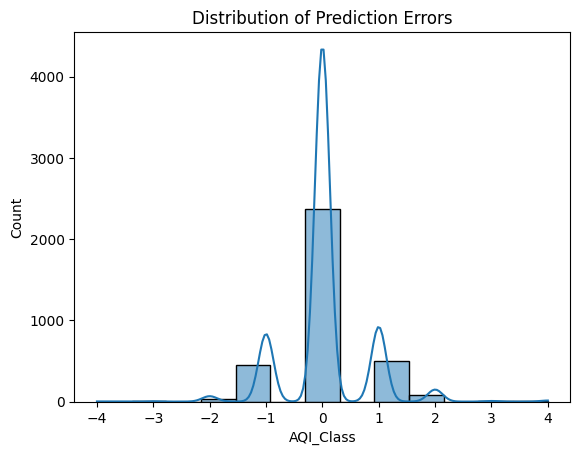

In [12]:
# Dự đoán và phân tích sai số
pred = clf.predict(X_test)
sns.histplot(y_test - pred, kde=True)
plt.title('Distribution of Prediction Errors')
plt.show()

In [17]:
# Tinh chỉnh siêu tham số
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
max_features = ['sqrt', 'log2']  
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10]
params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [ ]:
best_params = {
    'n_estimators': 100,
    'max_features': 'log2',
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

In [18]:
search = RandomizedSearchCV(clf, params, scoring='accuracy', cv=5, n_iter=100, random_state=43, n_jobs=-1)
search.fit(X, y)
print(f"Best parameters: {search.best_params_}")
print(f"Best accuracy: {search.best_score_}")

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 5}
Best accuracy: 0.5374594810324977


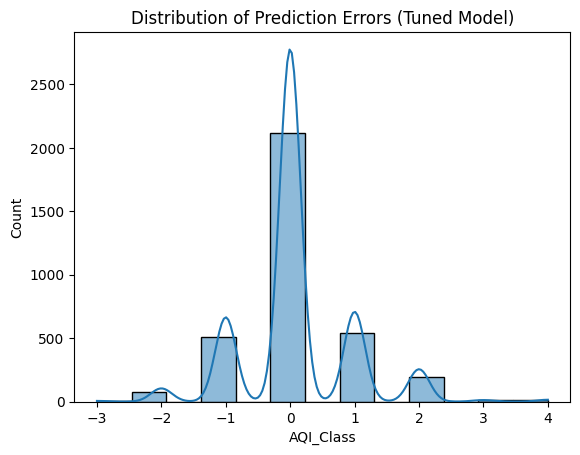

In [19]:
# Dự đoán với mô hình tốt nhất
pred = search.predict(X_test)
sns.histplot(y_test - pred, kde=True)
plt.title('Distribution of Prediction Errors (Tuned Model)')
plt.show()

In [ ]:
# Đánh giá mô hình tinh chỉnh
print(f"Accuracy: {metrics.accuracy_score(y_test, pred)}")
print(f"Classification Report:\n{metrics.classification_report(y_test, pred, zero_division=1)}")

# Lưu mô hình
pickle.dump(search, open('random-forest-classifier.pkl', 'wb'))

Accuracy: 0.6119316536345207
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.25      0.38       500
           1       0.60      0.94      0.73      1730
           2       0.94      0.03      0.05       636
           3       0.59      0.65      0.62       537
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        14

    accuracy                           0.61      3453
   macro avg       0.49      0.31      0.30      3453
weighted avg       0.69      0.61      0.53      3453



/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
print("Unique labels in y_test:", set(y_test))
print("Unique labels in pred:", set(pred))

Unique labels in y_test: {0, 1, 2, 3, 4, 5}
Unique labels in pred: {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
